In [97]:
import datetime
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import random
%matplotlib inline

print(f'MPS avaiable: {torch.backends.mps.is_available()}, build with: {torch.backends.mps.is_built()}')

device = 'mps' if torch.backends.mps.is_available() else \
  'cuda' if torch.backends.cuda.is_available() else \
  'cpu'

device = 'cpu'
print(f'Device: {device}')
print(f'Torch version: {torch.__version__}')
random.seed(0)
datafolder = './data/FMNIST'

fmnist = datasets.FashionMNIST(datafolder, download=True, train=True)

tr_images = fmnist.data
tr_targets = fmnist.targets

val_fmnist = datasets.FashionMNIST(datafolder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

MPS avaiable: True, build with: True
Device: cpu
Torch version: 1.13.0


In [98]:
class FMINSTDataset(Dataset):
    def __init__(self, x, y):
        #x = (x.float() -128) / 255
        x = x.float() / 255
        x = x.view(-1, 28*28)
        self.x, self.y = x, y
        
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    
    def __len__(self):
        return len(self.x)

In [110]:
# possiamo ottenere il model creando una rete ad N livelli sequenziale
# sfruttando nn.Sequential oppure in modo costruttivo diretto derivando
# da nn.Module e vedere in dettaglio cosa avviene su ogni layer
def get_model_direct(learning_rate=1e-3):
    model = nn.Sequential(
        #nn.Dropout(0.25),
        nn.Linear(28*28, 1000),
        nn.BatchNorm1d(1000),
        nn.ReLU(),
        #nn.Dropout(0.25),
        nn.Linear(1000, 10)
        ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = get_optimizer(model, learning_rate)
    return model, loss_fn, optimizer


def get_model_by_construction(learning_rate=1e-3):
    class Neuralnet(nn.Module):
        def __init__(self):
            super().__init__()
            #self.input_to_hidden_dropout = nn.Dropout(0.25)
            self.input_to_hidden_layer = nn.Linear(28*28, 1000)
            #self.batch_norm = nn.BatchNorm1d(1000)
            self.hidden_layer_activation = nn.ReLU()
            #self.hidden_to_output_dropout = nn.Dropout(0.25)
            self.hidden_to_output_layer = nn.Linear(1000, 10)
        def forward(self, x):
            #x = self.input_to_hidden_dropout(x)
            x = self.input_to_hidden_layer(x)
            #x = self.batch_norm(x)
            x = self.hidden_layer_activation(x)
            #x = self.hidden_to_output_dropout(x)
            x = self.hidden_to_output_layer(x)
            return x
    model = Neuralnet().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = get_optimizer(model, learning_rate)
    return model, loss_fn, optimizer

#get_model = get_model_direct
get_model = get_model_by_construction


In [111]:
from torch.optim import SGD, Adam

def get_optimizer(model, learning_rate):
    return Adam(model.parameters(), lr=learning_rate)

def l_regularization(model, l_type):
    l_regularization = 0
    l_gamma = l_type == 0.0001 if l_type == 1 else 0.01
    for p in model.parameters():
        l_regularization += torch.norm(p, l_norm_type)
    return l_gamma * l_regularization

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    # all'errore può essere aggiunta una valutazione dei pesi per evitare valori eccessivi degli stessi
    batch_loss = loss_fn(prediction, y) #+ l_regularization(model, 2)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [112]:
def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


In [113]:
def get_data():
    train = FMINSTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val_data = FMINSTDataset(val_images, val_targets)
    val_dl = DataLoader(val_data, batch_size=len(val_data), shuffle=False)
    return trn_dl, val_dl


In [139]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

def eval_out_probability(y):
    return np.exp(y) / np.sum(np.exp(y))

In [129]:
from torch import optim

N_EPOCHS = 5
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model(1e-3)
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
opt_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
    factor=0.5, patience=0, threshold=True, min_lr=1e-5, threshold_mode='abs', verbose=True)

t_start = datetime.datetime.now()

for epoch in range(N_EPOCHS):
    print(f'\nEpoch: {epoch} []')
    train_epoch_losses, train_epoch_accuracies = [], []
    print('\n\tTraining cicle: ', end='')
    for ix, batch in enumerate(iter(trn_dl)):
        print('.', end='') if ix%33 == 0 else ""
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    
    train_epoch_loss = np.array(train_epoch_losses).mean()
        
    print('\n\tAccuracy cicle on training data: ', end='')
    for ix, batch in enumerate(iter(trn_dl)):
        print('.', end='') if ix%33 == 0 else ""
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)

    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    print('\n\tAccuracy cicle on validation data: ', end='')
    for ix, batch in enumerate(iter(val_dl)):
        print('.', end='') if ix%33 == 0 else ""
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
        opt_scheduler.step(validation_loss)
        
    val_epoch_accuracy = np.mean(val_is_correct)    
    print(f' current accuracy {val_epoch_accuracy}', end='')
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

t_elapsed = datetime.datetime.now() - t_start
print(t_elapsed)

# 32/5 [ADAM] --> 31.2s accuracy >~85%
# 32/5 [SGD]  --> 17.3s accuracy <~85%
# 32/10 [SGD]  --> 35.8s accuracy >~85%
# 32/10 [ADAM]  --> 61.9s accuracy <~85% jumpy!
# >> 32/5 [ADAM] --> 29.67s accuracy 89% - with lr optimizer
# 32/5 [ADAM] --> 39.26s accuracy 89% - with lr optimizer & batc_norm
# 32/5 [ADAM] --> 41.26s accuracy ~88% - with lr optimizer & batc_norm & dropout
# 32/5 [ADAM] --> 50.80s accuracy ~86% - with lr optimizer & batc_norm & dropout & L1
# 32/5 [ADAM] --> 50.59s accuracy ~87% - with lr optimizer & batc_norm & dropout & L2


Epoch: 0 []

	Training cicle: .........................................................
	Accuracy cicle on training data: .........................................................
	Accuracy cicle on validation data: . current accuracy 0.8458
Epoch: 1 []

	Training cicle: .........................................................
	Accuracy cicle on training data: .........................................................
	Accuracy cicle on validation data: .Epoch 00002: reducing learning rate of group 0 to 5.0000e-04.
 current accuracy 0.8643
Epoch: 2 []

	Training cicle: .........................................................
	Accuracy cicle on training data: .........................................................
	Accuracy cicle on validation data: .Epoch 00003: reducing learning rate of group 0 to 2.5000e-04.
 current accuracy 0.8746
Epoch: 3 []

	Training cicle: .........................................................
	Accuracy cicle on training data: ...........................

# Verifichiamo i problemi che si possono riscontrare da una traslazione dell'immagine in input...

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 190, 198, 178, 183,
         182, 186, 184, 180, 188, 181,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   8, 253, 216, 210, 223,
         210, 194, 209, 204, 198, 223,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  64, 220, 205, 205, 219,
         214, 205, 208, 189, 191, 219,  16,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0, 122, 204, 205, 223, 214,
         215, 190, 214, 213, 198, 213,  87,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0, 174, 203, 203, 204, 201,
         212, 198, 201, 213, 182, 202, 137,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0, 222, 208, 199, 198, 222,
         211, 208, 230, 211, 197, 206, 149,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

Text(0.5, 1.0, 'Trouser')

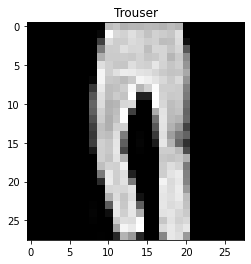

In [143]:
ix = 24300
img = tr_images[ix]
plt.imshow(img, cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]])


In [140]:
img_data = (img / 255.).view(28*28).to(device)
np_out = model(img_data).cpu().detach().numpy()
print(f'Out layer values: {np_out}')
prob = eval_out_probability(np_out)
print(f'\nNormalized probability: {prob}')

print(f'\nIdentified item: {fmnist.classes[np.argmax(prob)]}')

Out layer values: [ -0.12489169   5.7514467   -6.2410464   -3.3654857   -5.202911
 -18.068932    -5.164522   -24.878504    -9.6186075  -17.351116  ]

Normalized probability: [2.7967675e-03 9.9705178e-01 6.1722585e-06 1.0946727e-04 1.7430129e-05
 4.5046272e-11 1.8112261e-05 4.9693455e-14 2.1066286e-07 9.2342606e-11]

Identified item: Trouser


In [154]:
preds = []
for px in range(-5, 6):
    nn_in = (img / 255.).view(28,28)
    nn_in = torch.Tensor(np.roll(nn_in, px, axis=1))
    nn_in = nn_in.view(28*28).to(device)
    nn_out = model(nn_in).cpu().detach().numpy()
    preds.append(eval_out_probability(nn_out))

<AxesSubplot:title={'center':'Probability matrix'}>

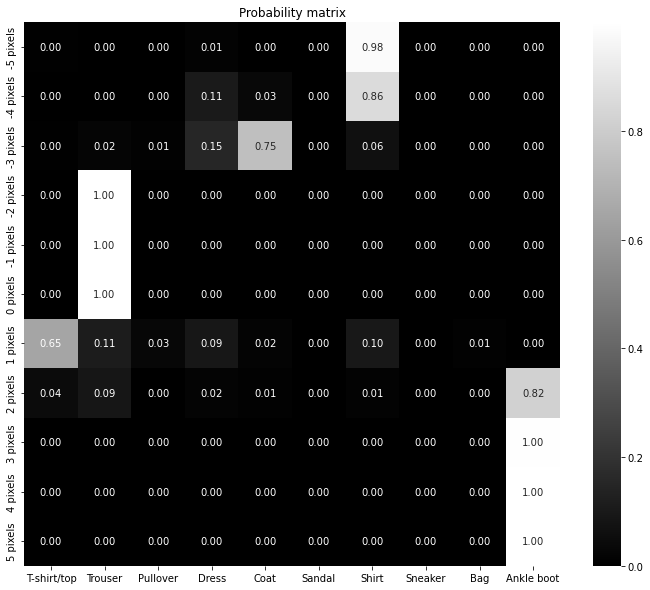

In [156]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.title('Probability matrix')

sns.heatmap(np.array(preds), annot=True, ax=ax, fmt='.2f', 
            xticklabels=fmnist.classes,
            yticklabels=[str(i)+str(' pixels') for i in range(-5,6)],
            cmap='gray')